# Signal Detection and Classification in Shared Spectrum with CNN and FDA

In [ ]:
IQ_PAIR = 512
CLASSES = ['wifi', 'lte', 'nr5g']
NUM_CLASSES = len(CLASSES)

## 1. Import Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install torchinfo
from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from scipy import signal
import seaborn as sns

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2. Dataset
Generated data can be also downloaded from [my Google Drive](https://drive.google.com/file/d/1sjkl9PG-CbqHMXUwUNx1jfrjSu0x9B2F/view?usp=sharing).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
! unzip -q "/content/gdrive/MyDrive/Colab Notebooks/CENG501 - Spring2021/Project/data.zip"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace wifi/wifi_CBW160_BCC_16QAM1-2_Long.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


### 2.1 WiFi Data

In [ ]:
wifi_files = glob.glob("/content/wifi/*.txt")
wifi_df = pd.DataFrame()

for f in sorted(wifi_files):
    csv = pd.read_csv(f, converters={'I+Qi': lambda s: np.complex(s.replace('i', 'j'))})
    wifi_df = wifi_df.append(csv)

### 2.2 LTE Data

In [ ]:
lte_files = glob.glob("/content/lte/*.txt")
lte_df = pd.DataFrame()

for f in sorted(lte_files):
    csv = pd.read_csv(f, converters={'I+Qi': lambda s: np.complex(s.replace('i', 'j'))})
    lte_df = lte_df.append(csv)

### 2.3 5G-NR Data

In [ ]:
nr5g_files = glob.glob("/content/nr5g/*.txt")
nr5g_df = pd.DataFrame()

for f in sorted(nr5g_files):
    csv = pd.read_csv(f, converters={'I+Qi': lambda s: np.complex(s.replace('i', 'j'))})
    nr5g_df = nr5g_df.append(csv)

### 2.4 Visualization



In [ ]:
n = 5000
sample = IQ_PAIR
begin, end = n, n + sample

#### 2.4.1 Time-Domain

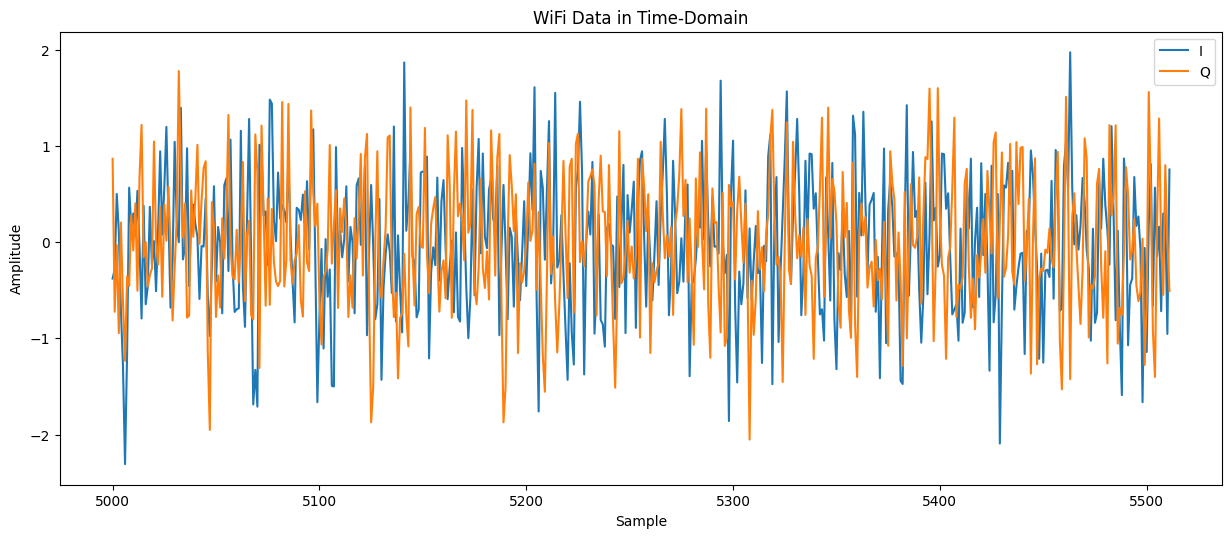

In [ ]:
plt.plot(wifi_df.apply(np.real).iloc[begin:end], label='I')
plt.plot(wifi_df.apply(np.imag).iloc[begin:end], label='Q')
plt.title('WiFi Data in Time-Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

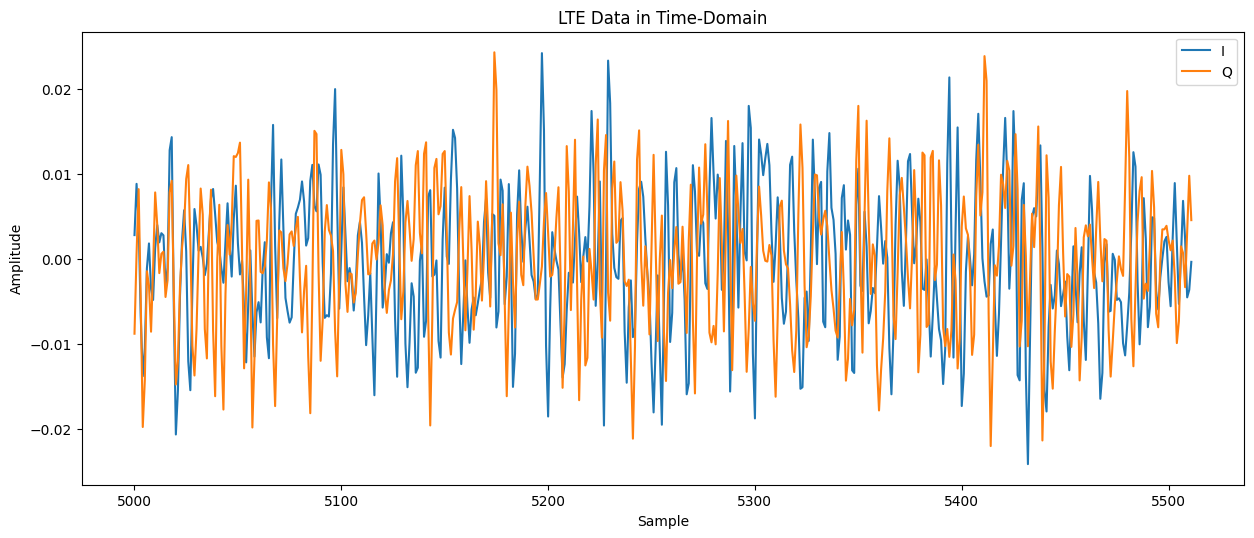

In [ ]:
plt.plot(lte_df.apply(np.real).iloc[begin:end], label='I')
plt.plot(lte_df.apply(np.imag).iloc[begin:end], label='Q')
plt.title('LTE Data in Time-Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

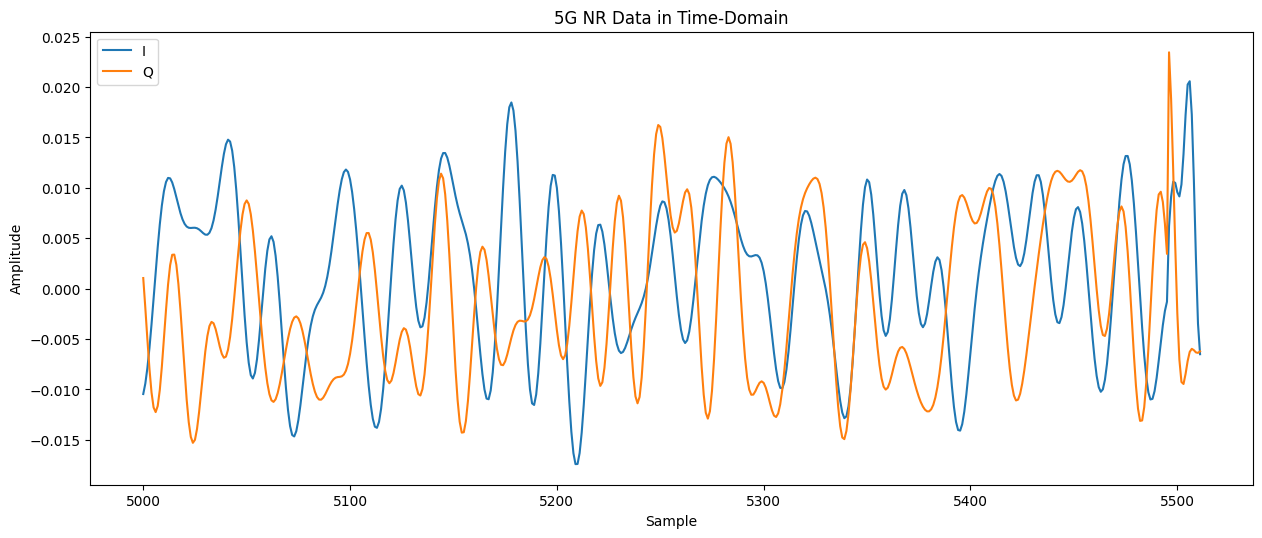

In [ ]:
plt.plot(nr5g_df.apply(np.real).iloc[begin:end], label='I')
plt.plot(nr5g_df.apply(np.imag).iloc[begin:end], label='Q')
plt.title('5G NR Data in Time-Domain')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### 2.4.2 Constellation Scheme

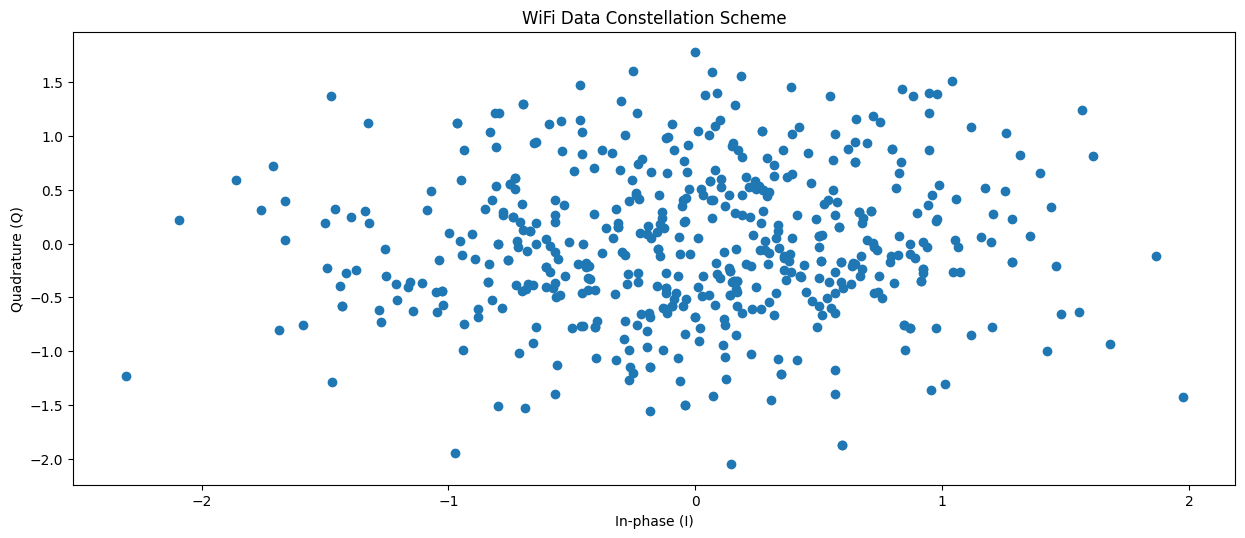

In [ ]:
plt.scatter(wifi_df.apply(np.real).iloc[begin:end], wifi_df.apply(np.imag).iloc[begin:end])
plt.title('WiFi Data Constellation Scheme')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.show()

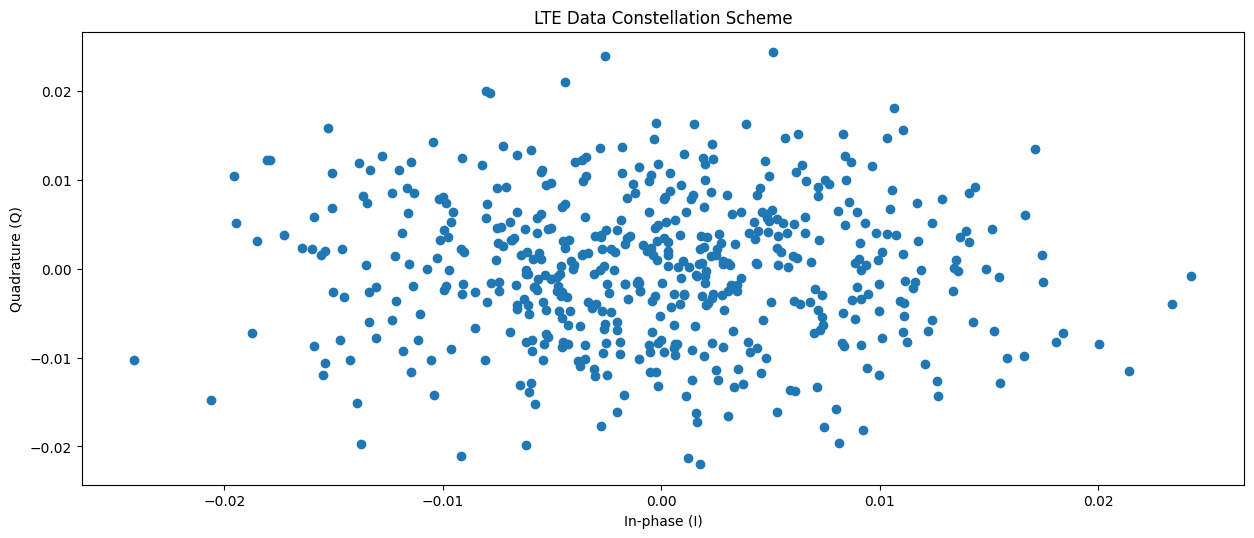

In [ ]:
plt.scatter(lte_df.apply(np.real).iloc[begin:end], lte_df.apply(np.imag).iloc[begin:end])
plt.title('LTE Data Constellation Scheme')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.show()

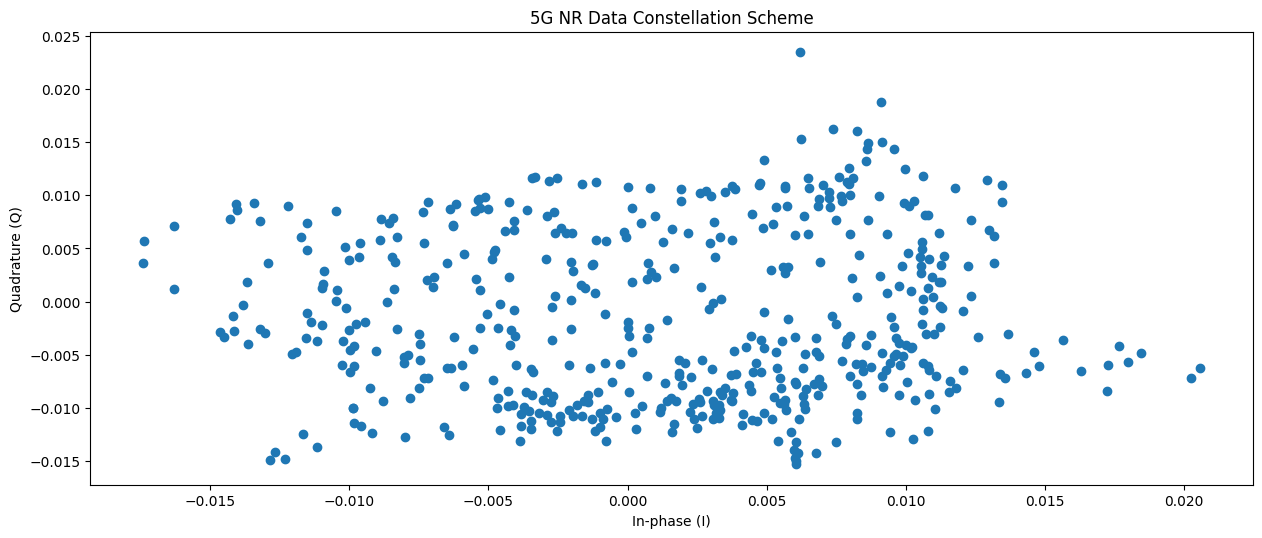

In [ ]:
plt.scatter(nr5g_df.apply(np.real).iloc[begin:end], nr5g_df.apply(np.imag).iloc[begin:end])
plt.title('5G NR Data Constellation Scheme')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.show()

#### 2.4.3 Frequency Domain

In [ ]:
def STFT(s, fs=2.4e9, n=IQ_PAIR, axis=1, beta=14):
    kaiser_window = signal.windows.kaiser(n, beta=beta)
    f, t, Zxx = signal.stft(s, fs=fs, window=kaiser_window, nperseg=n, return_onesided=False, axis=axis)
    return f, t, Zxx

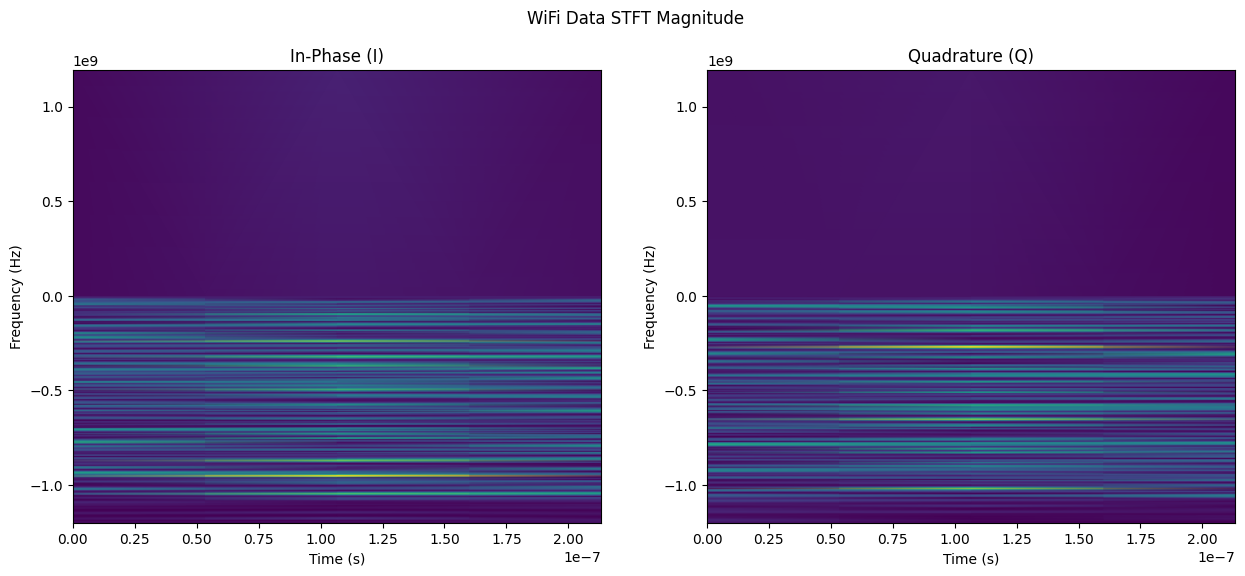

In [ ]:
wifi_signal = wifi_df.iloc[begin:end].to_numpy().reshape(-1)
f, t, Zxx = STFT(wifi_signal, n=sample, axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('WiFi Data STFT Magnitude')

ax1.pcolormesh(t, f, np.abs(Zxx.real), vmin=0, vmax=np.abs(Zxx.real).max(), shading='gouraud')
ax1.set_title('In-Phase (I)')
ax1.set(xlabel='Time (s)', ylabel='Frequency (Hz)')

ax2.pcolormesh(t, f, np.abs(Zxx.imag), vmin=0, vmax=np.abs(Zxx.imag).max(), shading='gouraud')
ax2.set_title('Quadrature (Q)')
ax2.set(xlabel='Time (s)', ylabel='Frequency (Hz)')
fig.show()

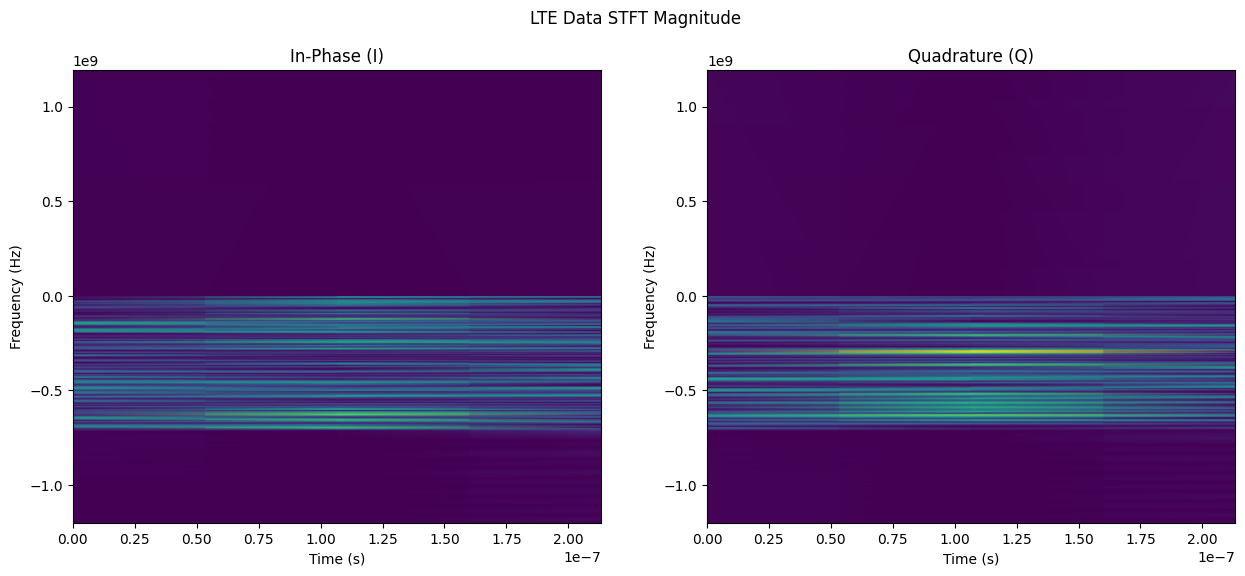

In [ ]:
lte_signal = lte_df.iloc[begin:end].to_numpy().reshape(-1)
f, t, Zxx = STFT(lte_signal, n=sample, axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('LTE Data STFT Magnitude')

ax1.pcolormesh(t, f, np.abs(Zxx.real), vmin=0, vmax=np.abs(Zxx.real).max(), shading='gouraud')
ax1.set_title('In-Phase (I)')
ax1.set(xlabel='Time (s)', ylabel='Frequency (Hz)')

ax2.pcolormesh(t, f, np.abs(Zxx.imag), vmin=0, vmax=np.abs(Zxx.imag).max(), shading='gouraud')
ax2.set_title('Quadrature (Q)')
ax2.set(xlabel='Time (s)', ylabel='Frequency (Hz)')
fig.show()

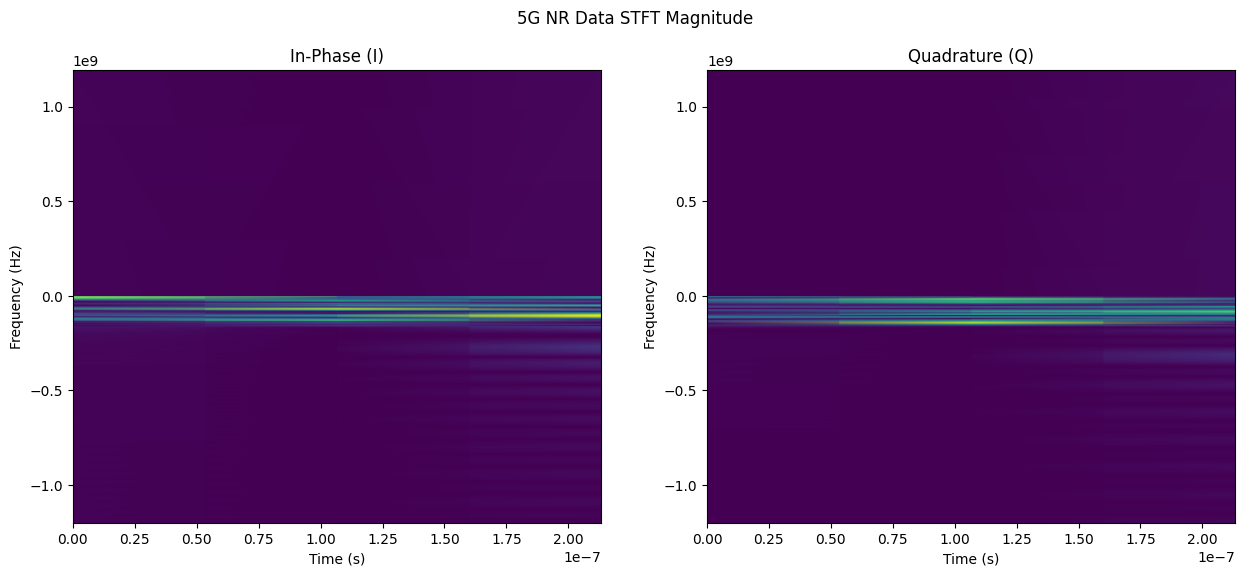

In [ ]:
nr5g_signal = nr5g_df.iloc[begin:end].to_numpy().reshape(-1)
f, t, Zxx = STFT(nr5g_signal, n=sample, axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('5G NR Data STFT Magnitude')

ax1.pcolormesh(t, f, np.abs(Zxx.real), vmin=0, vmax=np.abs(Zxx.real).max(), shading='gouraud')
ax1.set_title('In-Phase (I)')
ax1.set(xlabel='Time (s)', ylabel='Frequency (Hz)')

ax2.pcolormesh(t, f, np.abs(Zxx.imag), vmin=0, vmax=np.abs(Zxx.imag).max(), shading='gouraud')
ax2.set_title('Quadrature (Q)')
ax2.set(xlabel='Time (s)', ylabel='Frequency (Hz)')
fig.show()

## 3. Pre-Processing

In [ ]:
wifi_complex_data = wifi_df.to_numpy()

n, p = wifi_complex_data.shape
n_leftout = n % IQ_PAIR
n_pair = n // IQ_PAIR

if n_leftout == 0:
    wifi_complex_data = wifi_complex_data.reshape(n_pair, IQ_PAIR)
else:
    wifi_complex_data = wifi_complex_data[:-n_leftout].reshape(n_pair, IQ_PAIR)

_, _, wifi_sftf_data = STFT(wifi_complex_data)

# wifi_complex_data = wifi_complex_data.reshape(n_pair, IQ_PAIR, 1)
# wifi_complex_data = np.concatenate((wifi_complex_data, wifi_sftf_data), axis=-1)
wifi_complex_data = wifi_sftf_data

n_pair, iq_pair, p = wifi_complex_data.shape

wifi_data = np.zeros((n_pair, 2, iq_pair, p))
wifi_data[:, 0, :, :] = wifi_complex_data.real
wifi_data[:, 1, :, :] = wifi_complex_data.imag

print(wifi_data.shape)

(14410, 2, 512, 3)


In [ ]:
lte_complex_data = lte_df.to_numpy()

n, p = lte_complex_data.shape
n_leftout = n % IQ_PAIR
n_pair = n // IQ_PAIR

if n_leftout == 0:
    lte_complex_data = lte_complex_data.reshape(n_pair, IQ_PAIR)
else:
    lte_complex_data = lte_complex_data[:-n_leftout].reshape(n_pair, IQ_PAIR)

_, _, lte_sftf_data = STFT(lte_complex_data)

# lte_complex_data = lte_complex_data.reshape(n_pair, IQ_PAIR, 1)
# lte_complex_data = np.concatenate((lte_complex_data, lte_sftf_data), axis=-1)
lte_complex_data = lte_sftf_data

n_pair, iq_pair, p = lte_complex_data.shape

lte_data = np.zeros((n_pair, 2, iq_pair, p))
lte_data[:, 0, :, :] = lte_complex_data.real
lte_data[:, 1, :, :] = lte_complex_data.imag

print(lte_data.shape)

(13972, 2, 512, 3)


In [ ]:
nr5g_complex_data = nr5g_df.to_numpy()

n, p = nr5g_complex_data.shape
n_leftout = n % IQ_PAIR
n_pair = n // IQ_PAIR

if n_leftout == 0:
    nr5g_complex_data = nr5g_complex_data.reshape(n_pair, IQ_PAIR)
else:
    nr5g_complex_data = nr5g_complex_data[:-n_leftout].reshape(n_pair, IQ_PAIR)

_, _, nr5g_sftf_data = STFT(nr5g_complex_data)

# nr5g_complex_data = nr5g_complex_data.reshape(n_pair, IQ_PAIR, 1)
# nr5g_complex_data = np.concatenate((nr5g_complex_data, nr5g_sftf_data), axis=-1)
nr5g_complex_data = nr5g_sftf_data

n_pair, iq_pair, p = nr5g_complex_data.shape

nr5g_data = np.zeros((n_pair, 2, iq_pair, p))
nr5g_data[:, 0, :, :] = nr5g_complex_data.real
nr5g_data[:, 1, :, :] = nr5g_complex_data.imag

print(nr5g_data.shape)

(16170, 2, 512, 3)


In [ ]:
wifi_label = np.full((wifi_data.shape[0]), CLASSES.index("wifi"))
lte_label = np.full((lte_data.shape[0]), CLASSES.index("lte"))
nr5g_label = np.full((nr5g_data.shape[0]), CLASSES.index("nr5g"))

data = np.concatenate((wifi_data, lte_data, nr5g_data))
label = np.concatenate((wifi_label, lte_label, nr5g_label))

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=501)
train_data.shape, test_data.shape, train_label.shape, test_label.shape

((35641, 2, 512, 3), (8911, 2, 512, 3), (35641,), (8911,))

## 4. Model

In [ ]:
class cnnClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        torch.manual_seed(501)
        random.seed(501)
        np.random.seed(501)

        # Input: 2, 512, 3
        self.conv1_1 = nn.Conv2d(2, 4, kernel_size=(3,3), stride=(1,1), padding=(1,1))      # 4, 512, 3
        self.conv1_2 = nn.Conv2d(4, 4, kernel_size=(3,3), stride=(1,1), padding=(1,1))      # 4, 512, 3
        self.conv1_3 = nn.Conv2d(4, 4, kernel_size=(3,3), stride=(1,1), padding=(1,1))      # 4, 512, 3
        self.batchNorm1 = nn.BatchNorm2d(4)
        self.maxPool1 = nn.MaxPool2d(kernel_size=(2,3), stride=(2,1), padding=(0,1))        # 4, 256, 3
        self.conv2_1 = nn.Conv2d(4, 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))      # 8, 256, 3
        self.conv2_2 = nn.Conv2d(8, 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))      # 8, 256, 3
        self.conv2_3 = nn.Conv2d(8, 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))      # 8, 256, 3
        self.batchNorm2 = nn.BatchNorm2d(8)
        self.maxPool2 = nn.MaxPool2d(kernel_size=(2,3), stride=(2,1), padding=(0,1))        # 8, 128, 3
        self.conv3_1 = nn.Conv2d(8, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))     # 16, 128, 3
        self.conv3_2 = nn.Conv2d(16, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))    # 16, 128, 3
        self.conv3_3 = nn.Conv2d(16, 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))    # 16, 128, 3
        self.batchNorm3 = nn.BatchNorm2d(16)
        self.maxPool3 = nn.MaxPool2d(kernel_size=(2,3), stride=(2,1), padding=(0,1))        # 16, 64, 3
        self.fc1 = nn.Linear(3072, 256)
        self.fc2 = nn.Linear(256, NUM_CLASSES)

    def forward(self, x):
        x = F.selu(self.conv1_1(x))
        x = F.selu(self.conv1_2(x))
        x = F.selu(self.conv1_3(x))
        x = self.batchNorm1(x)
        x = self.maxPool1(x)
        
        x = F.selu(self.conv2_1(x))
        x = F.selu(self.conv2_2(x))
        x = F.selu(self.conv2_3(x))
        x = self.batchNorm2(x)
        x = self.maxPool2(x)
        
        x = F.selu(self.conv3_1(x))
        x = F.selu(self.conv3_2(x))
        x = F.selu(self.conv3_3(x))
        x = self.batchNorm3(x)
        x = self.maxPool3(x)
        
        N, C, H, W = x.shape
        x = x.reshape(N, C*H*W)
        x = F.selu(self.fc1(x))
        x = self.fc2(x)

        return x

## 5. Training

In [ ]:
def chunks(data, label, batch_size):
    for i in range(0, data.shape[0], batch_size):
        yield data[i:i + batch_size], label[i:i + batch_size]

def train(model, criterion, optimizer, dataloader, batch_size=64, learning_rate=1e-3, epochs=25, verbose=True):

    train_data, train_label, test_data, test_label = dataloader
    train_history, test_history = [], []

    for e in range(epochs):
        for batch_data, batch_label in chunks(train_data, train_label, batch_size):
            inputs = torch.from_numpy(batch_data).float().to(device)
            labels = torch.from_numpy(batch_label).to(device)

            optimizer.zero_grad()
            predictions = model(inputs).to(device)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():
            train_inputs = torch.from_numpy(train_data).float().to(device)
            train_labels = torch.from_numpy(train_label).to(device)
            train_predictions = model(train_inputs).to(device)
            train_loss = criterion(train_predictions, train_labels)
            train_history.append(train_loss.item())

            test_inputs = torch.from_numpy(test_data).float().to(device)
            test_labels = torch.from_numpy(test_label).to(device)
            test_predictions = model(test_inputs).to(device)
            test_loss = criterion(test_predictions, test_labels)
            test_history.append(test_loss.item())

            if verbose:
                print(f"Epoch {e} - Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}")
        
    return model.eval(), train_history, test_history

In [ ]:
batch_size = 128
learning_rate = 1e-4
epochs = 100

model = cnnClassifier().to(device)
print(summary(model, input_size=(batch_size, 2, IQ_PAIR, 3)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

dataloader = (train_data, train_label, test_data, test_label)
model, train_history, test_history = train(model, criterion, optimizer, dataloader, batch_size, learning_rate, epochs)

Layer (type:depth-idx)                   Output Shape              Param #
cnnClassifier                            --                        --
├─Conv2d: 1-1                            [128, 4, 512, 3]          76
├─Conv2d: 1-2                            [128, 4, 512, 3]          148
├─Conv2d: 1-3                            [128, 4, 512, 3]          148
├─BatchNorm2d: 1-4                       [128, 4, 512, 3]          8
├─MaxPool2d: 1-5                         [128, 4, 256, 3]          --
├─Conv2d: 1-6                            [128, 8, 256, 3]          296
├─Conv2d: 1-7                            [128, 8, 256, 3]          584
├─Conv2d: 1-8                            [128, 8, 256, 3]          584
├─BatchNorm2d: 1-9                       [128, 8, 256, 3]          16
├─MaxPool2d: 1-10                        [128, 8, 128, 3]          --
├─Conv2d: 1-11                           [128, 16, 128, 3]         1,168
├─Conv2d: 1-12                           [128, 16, 128, 3]         2,320
├─Con

## 6. Analyzing

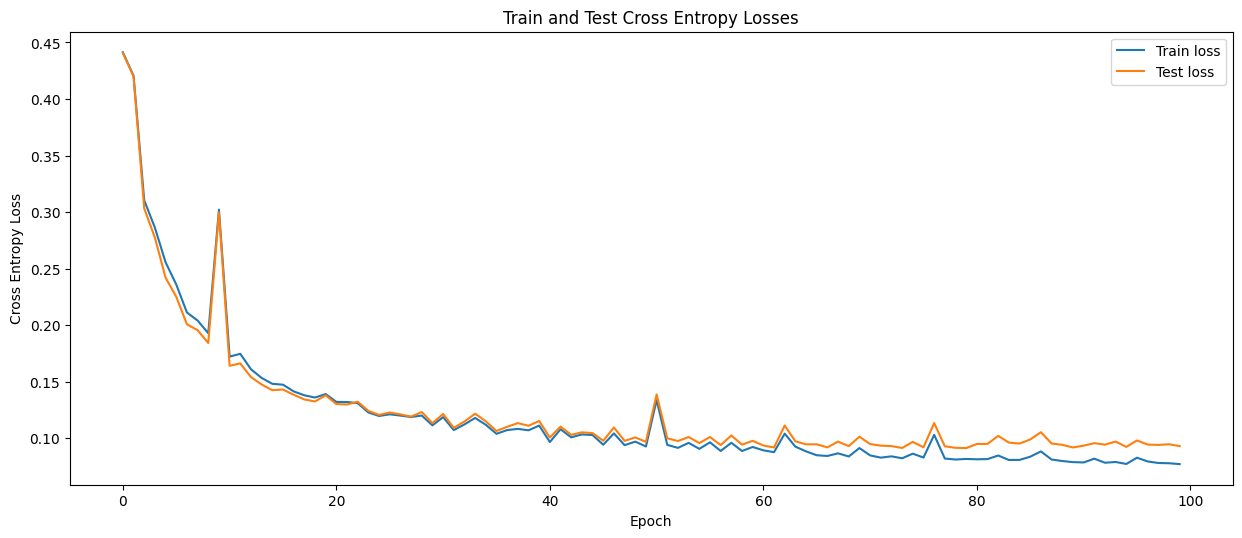

In [ ]:
plt.plot(train_history, label='Train loss')
plt.plot(test_history, label='Test loss')
plt.title('Train and Test Cross Entropy Losses')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()

Classification Accuracy: 0.9608349231287173


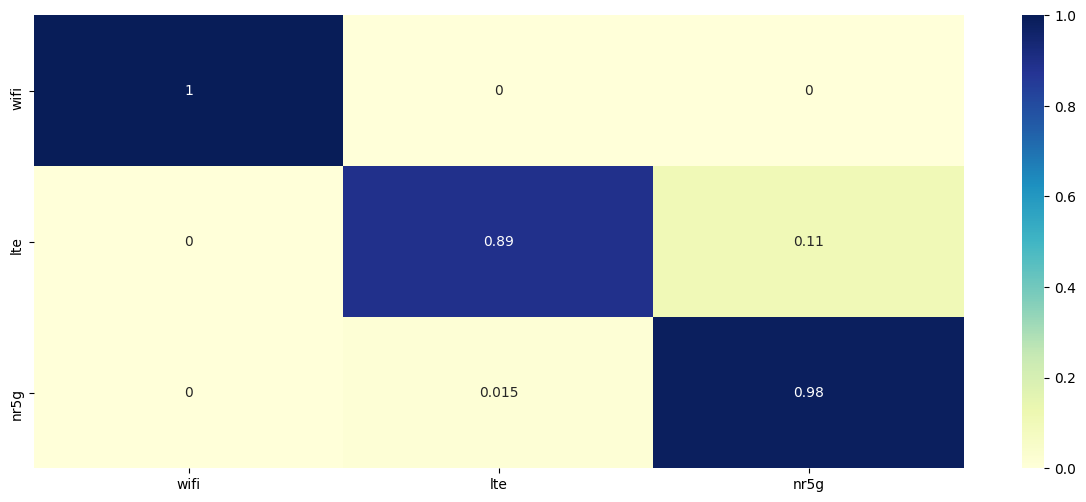

In [ ]:
with torch.no_grad():
    test_inputs = torch.from_numpy(test_data).float().to(device)
    test_labels = torch.from_numpy(test_label).to(device)
    test_predictions = model(test_inputs).to(device)
    test_loss = criterion(test_predictions, test_labels)

preds = test_predictions.cpu().detach().numpy().argmax(axis=1)
accuracy = np.mean(preds == test_label)
print(f"Classification Accuracy: {accuracy}")
confusion = confusion_matrix(test_label, preds, normalize='true')
heatmap = sns.heatmap(confusion, annot=True, xticklabels=CLASSES, yticklabels=CLASSES, cmap="YlGnBu")